In [2]:

import pandas as pd
import matplotlib.pyplot as plt


In [3]:
#using the csv files to load data_1,data_2,data_3 
data_1=pd.read_csv("data_1.csv")
data_2=pd.read_csv("data_2.csv")
data_3=pd.read_csv("data_3.csv")

#using date as index
data_1=data_1.set_index("Date")
data_2=data_2.set_index("Date")
data_3=data_3.set_index("Date")


In [4]:
#MSFT

#this can be changed accordingly
X=data_2
test_size=0.2



# analysis using first data
train_size=int((1-test_size)*len(X))
X_train,X_test=X.iloc[:train_size],X.iloc[train_size:]
print(X_train.shape,X_test.shape)

(634, 1) (159, 1)


In [5]:
X.describe()

,MSFT
count,793.000000
mean,342.790661
std,73.835584
min,209.393265
25%,268.021362
50%,343.712860
75%,412.296448
max,464.002502


In [6]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Index: 793 entries, 2022-04-01 to 2025-05-30
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   MSFT    793 non-null    float64
dtypes: float64(1)
memory usage: 12.4+ KB


In [7]:
X.head()

,MSFT
Date,
2022-04-01,301.064148
2022-04-04,306.464233
2022-04-05,302.484772
2022-04-06,291.412079
2022-04-07,293.231537


In [8]:
#testting for the stationarity of the chosen series
#using Dickey-Fuller test
from statsmodels.tsa.stattools import adfuller

def test_stationarity_adf(timeseries,autolag="AIC",maxlag=None):

    '''
    lag: can be "AIC" or "BIC"
    '''

    print("Results of Dickey-Fuller Test:")
    dftest=adfuller(timeseries,autolag=autolag,maxlag=maxlag)
    # Format results
    df_output = pd.Series(dftest[0:4], index=[
        "Test Statistic", 
        "p-value",
        "#Lags Used", 
        "Number of Observations Used"
    ])
    return df_output
test_stationarity_adf(X_train,maxlag=None,autolag="BIC")



Results of Dickey-Fuller Test:


Test Statistic                  -0.495290
p-value                          0.892932
#Lags Used                       0.000000
Number of Observations Used    633.000000
dtype: float64

In [9]:
# above result shows that series is not stationary . We now check for the first differece.
test_stationarity_adf(X_train.diff().dropna(),maxlag=None,autolag="AIC")


Results of Dickey-Fuller Test:


Test Statistic                 -19.694242
p-value                          0.000000
#Lags Used                       1.000000
Number of Observations Used    631.000000
dtype: float64

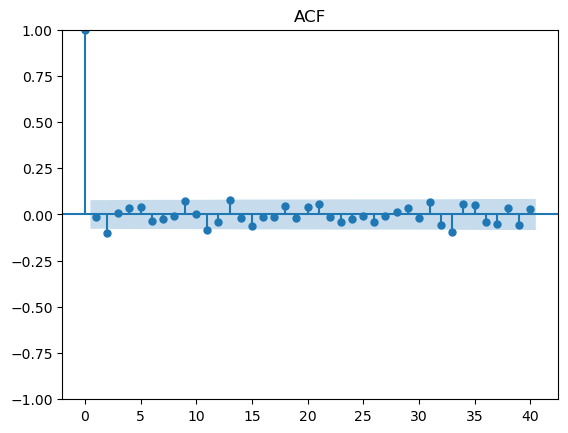

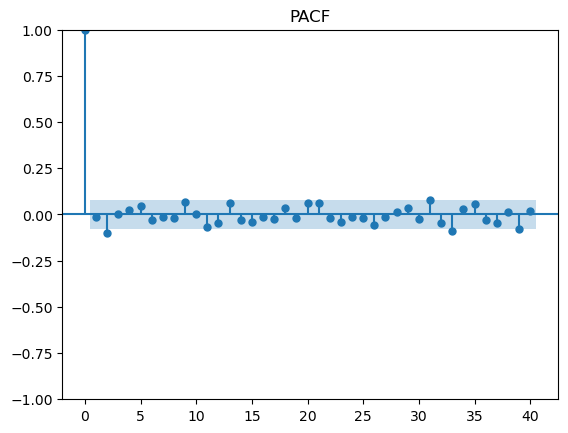

In [10]:
diff_series = X_train.diff().dropna()


from statsmodels.graphics.tsaplots import plot_acf, plot_pacf


plot_acf(diff_series, lags=40)
plt.title("ACF")
plt.show()

plot_pacf(diff_series, lags=40)
plt.title("PACF")
plt.show()

 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=3871.683, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3873.553, Time=0.06 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=3869.584, Time=0.10 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=3871.406, Time=0.16 sec
 ARIMA(0,1,4)(0,0,0)[0] intercept   : AIC=3872.872, Time=0.20 sec
 ARIMA(0,1,5)(0,0,0)[0] intercept   : AIC=3874.066, Time=0.26 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=3873.579, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3874.076, Time=0.17 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3871.470, Time=0.21 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=3872.964, Time=0.30 sec
 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=3874.664, Time=0.36 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=3869.225, Time=0.10 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=3871.213, Time=0.18 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3868.123, Time=0.51 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=3869.778, Time=0.67 sec
 ARIMA(3,1

C:\Users\91933\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\91933\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


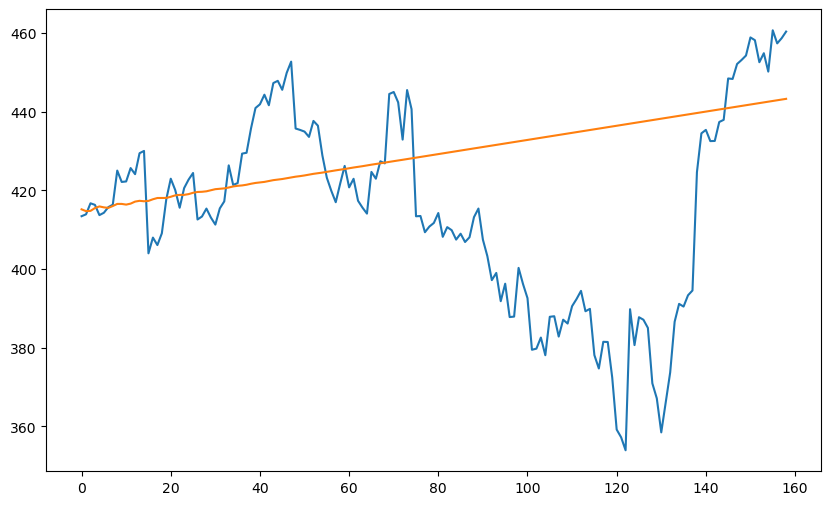

In [11]:
from pmdarima.model_selection import RollingForecastCV
from pmdarima.arima import auto_arima
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error

cv = RollingForecastCV(h=10, initial=0.8)  # 80% initial train, rolling forecast

model_arima = auto_arima(X_train,
                   d=1,
                   start_p=0, max_p=40,
                   start_q=0, max_q=40,
                   seasonal=False,
                   cv=cv,
                   stepwise=False,  # exhaustive search
                   error_action='ignore',
                   suppress_warnings=True,
                   trace=True,
                   scoring='mse')

print(model_arima.summary())



model_arima.fit(X_train)
n_periods = len(X_test)
forecast = model_arima.predict(n_periods=n_periods)



plt.figure(figsize=(10,6))
X_test=X_test.reset_index(drop=True)
forecast.reset_index(drop=True,inplace=True)

plt.plot(X_test)


plt.plot(forecast)
plt.show()



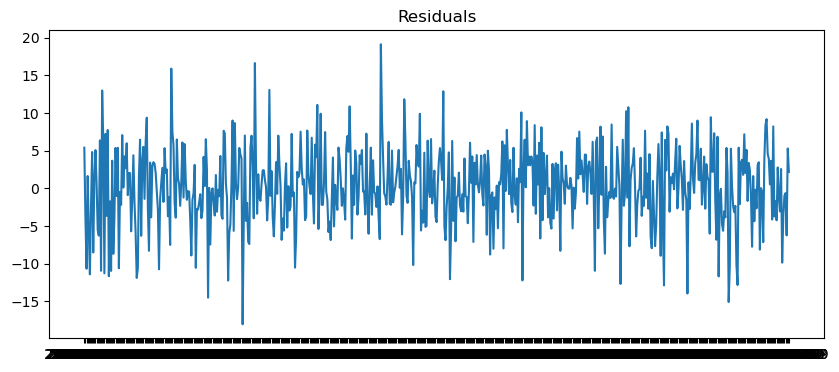

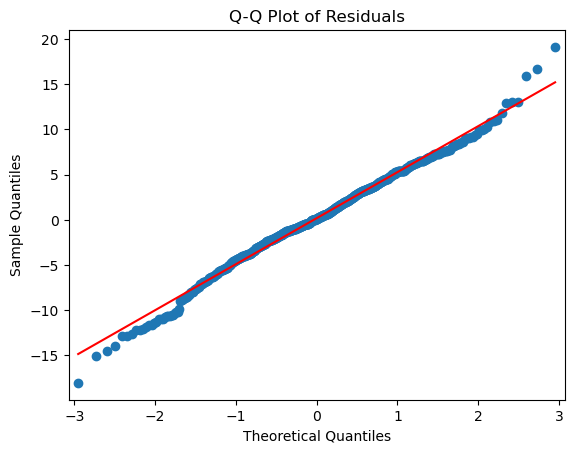

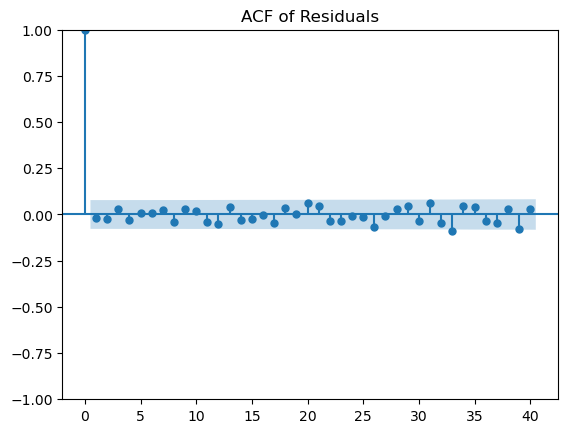

In [12]:
from statsmodels.tsa.arima.model import ARIMA

import warnings

warnings.filterwarnings("ignore")

model=ARIMA(X_train,order=(2,1,2))
model_fit=model.fit()

residuals=model_fit.resid
residuals=residuals.iloc[1:]



import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

# Residual plot
plt.figure(figsize=(10, 4))
plt.plot(residuals)
plt.title("Residuals")
plt.show()

# Q-Q plot
sm.qqplot(residuals, line='s')
plt.title("Q-Q Plot of Residuals")
plt.show()

# ACF of residuals
sm.graphics.tsa.plot_acf(residuals, lags=40)
plt.title("ACF of Residuals")
plt.show()



In [13]:
from statsmodels.stats.diagnostic import acorr_ljungbox

# residuals is typically model_fit.resid
lb_test = acorr_ljungbox(residuals, lags=[10,20,30,35], return_df=True)
print(lb_test)

      lb_stat  lb_pvalue
10   3.937969   0.950102
20  13.307068   0.863824
30  22.115806   0.849798
35  33.975879   0.517403


In [14]:
from scipy.stats import shapiro


stat, p = shapiro(residuals)
print("Shapiro-Wilk Test Statistic =", stat)
print("p-value =", p,"\n")

if p > 0.05:
    print("Residuals are likely normally distributed (fail to reject H_0)")
else:
    print("Residuals are not normally distributed (reject H_0)")


Shapiro-Wilk Test Statistic = 0.9928306937217712
p-value = 0.003954282961785793 

Residuals are not normally distributed (reject H_0)


3 stage Walk-Forward RMSE: 11.5155


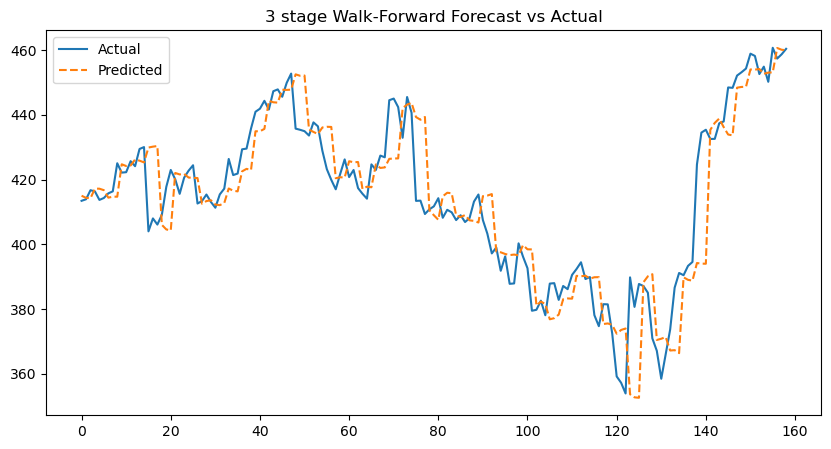

In [15]:
import numpy as np
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# Flatten and convert to float
X_train_flat = X_train.values.ravel() if hasattr(X_train, 'values') else np.ravel(X_train)
X_test_flat = X_test.values.ravel() if hasattr(X_test, 'values') else np.ravel(X_test)

train = list(X_train_flat.astype(float))
test = list(X_test_flat.astype(float))

predictions = []
order = (2, 1, 2)  # Replace with optimal order
step_size = 3

for t in range(0, len(test), step_size):
    model = ARIMA(np.array(train), order=order)
    model_fit = model.fit()
    
    # Forecast up to 5 steps ahead (or fewer at the end)
    steps = min(step_size, len(test) - t)
    forecast = model_fit.forecast(steps=steps)
    predictions.extend(forecast)
    
    # Update train with the actual next 5 values
    actuals = test[t:t + steps]
    train.extend(actuals)

# Evaluation and plot
rmse = np.sqrt(mean_squared_error(test[:len(predictions)], predictions))
print(f"{step_size} stage Walk-Forward RMSE: {rmse:.4f}")

plt.figure(figsize=(10, 5))
plt.plot(test, label='Actual')
plt.plot(predictions, label='Predicted', linestyle='--')
plt.legend()
plt.title(f"{step_size} stage Walk-Forward Forecast vs Actual")
plt.show()


In [16]:
from arch import arch_model
from statsmodels.stats.diagnostic import het_arch

lags=range(10,30,5)

# ARCH LM test from statsmodels
for lag in lags:
    lm_test = het_arch(residuals, nlags=lag) 
    print(f"Results of Arch LM test for ARIMA residuals for lags= {lag}")
    print("LM Stat:", lm_test[0])
    print("p-value:", lm_test[1])
    print("\n")


Results of Arch LM test for ARIMA residuals for lags= 10
LM Stat: 4.3792024344882385
p-value: 0.9286235452750842


Results of Arch LM test for ARIMA residuals for lags= 15
LM Stat: 16.030389022956463
p-value: 0.38003486167594475


Results of Arch LM test for ARIMA residuals for lags= 20
LM Stat: 15.163515632436486
p-value: 0.7669759725175915


Results of Arch LM test for ARIMA residuals for lags= 25
LM Stat: 22.427710472292027
p-value: 0.6109428108542551




In [17]:
from arch import arch_model

best_aic = float('inf')
best_order = None
best_model = None

for p in range(1, 10):   # GARCH lags
    for q in range(1, 10):  # ARCH lags
        try:
            model = arch_model(residuals, vol='GARCH', p=p, q=q)
            fitted = model.fit(disp="off")
            if fitted.aic < best_aic:
                best_aic = fitted.aic
                best_order = (p, q)
                best_model = fitted
        except:
            continue

print(f"Best GARCH order: p={best_order[0]}, q={best_order[1]}")
print(f"Lowest AIC: {best_aic}")


Best GARCH order: p=1, q=1
Lowest AIC: 3854.1749763059106


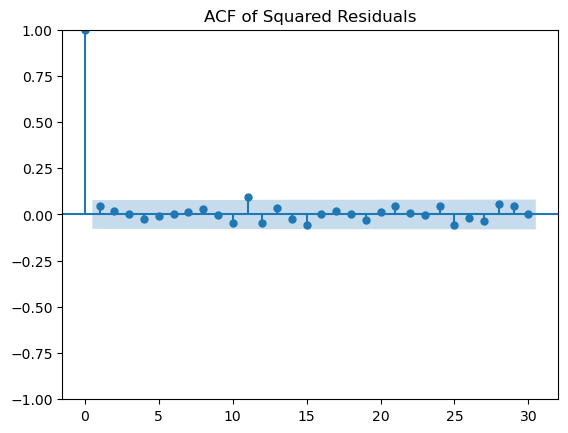

In [18]:
import statsmodels.api as sm
import matplotlib.pyplot as plt

sm.graphics.tsa.plot_acf(residuals**2, lags=30)
plt.title("ACF of Squared Residuals")
plt.show()


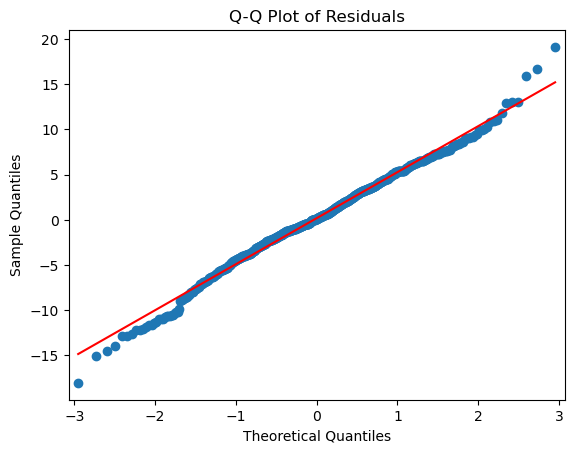

In [19]:
# Q-Q plot
sm.qqplot(residuals, line='s')
plt.title("Q-Q Plot of Residuals")


plt.savefig("plot_12.png", dpi=300, bbox_inches='tight')# Options: png, jpg, pdf, svg

plt.show()
plt.close()


In [20]:
from scipy.stats import jarque_bera

jb_stat, p = jarque_bera(residuals)
print(f"Jarque-Bera p-value: {p}")


Jarque-Bera p-value: 0.0027317703535015836


In [21]:
from scipy.stats import skew
skewness_value = skew(residuals)

print(f"Skewness = {skewness_value:.4f}")


Skewness = -0.1707


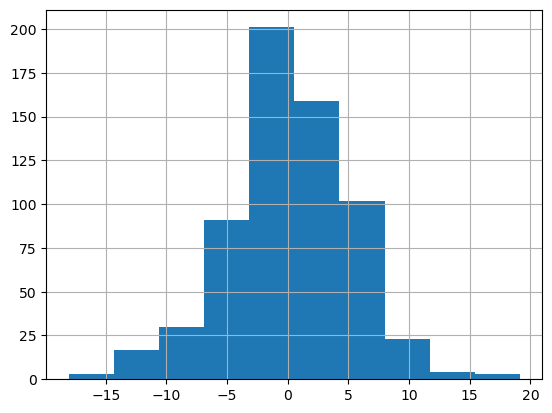

In [22]:
plt.hist(residuals);
plt.grid(True)


GARCH Summary:
                         Constant Mean - GARCH Model Results                         
Dep. Variable:                         None   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                            GARCH   Log-Likelihood:               -1919.73
Distribution:      Standardized Student's t   AIC:                           3849.45
Method:                  Maximum Likelihood   BIC:                           3871.71
                                              No. Observations:                  633
Date:                      Wed, Jul 02 2025   Df Residuals:                      632
Time:                              08:06:54   Df Model:                            1
                               Mean Model                               
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------

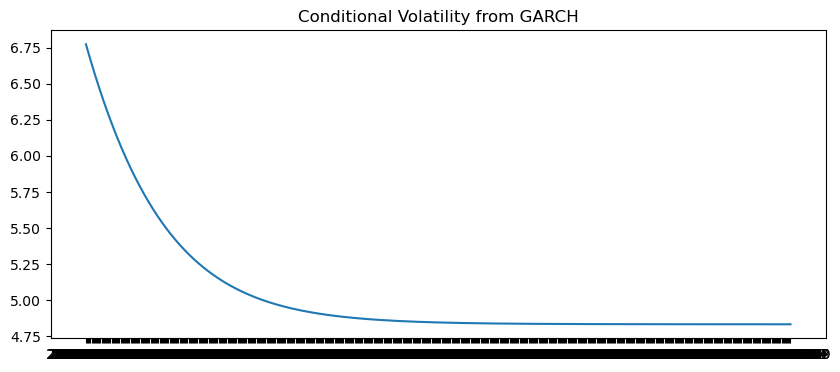

In [23]:
from arch import arch_model
garch_model = arch_model(residuals, vol='GARCH', p=1, q=1, dist='t')  # or dist='t'
garch_result = garch_model.fit(disp='off')


print("\nGARCH Summary:\n", garch_result.summary())


plt.figure(figsize=(10, 4))
plt.plot(garch_result.conditional_volatility)
plt.title("Conditional Volatility from GARCH")
plt.savefig("plot_22.png", dpi=300, bbox_inches='tight')# Options: png, jpg, pdf, svg
plt.show()

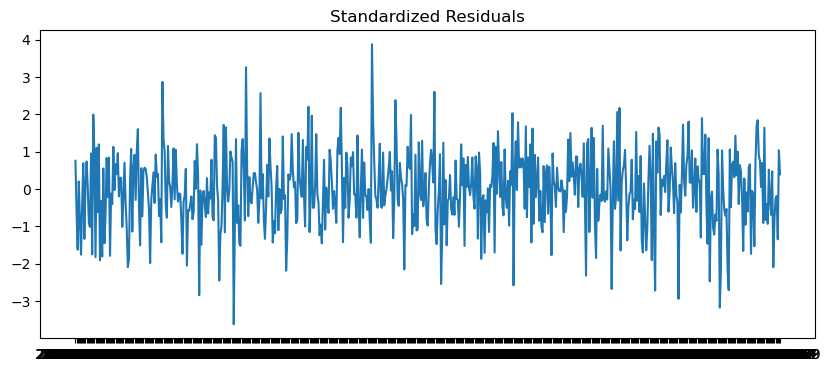

In [24]:
std_resid = garch_result.std_resid

plt.figure(figsize=(10,4))
plt.plot(std_resid)
plt.title("Standardized Residuals")
plt.show()

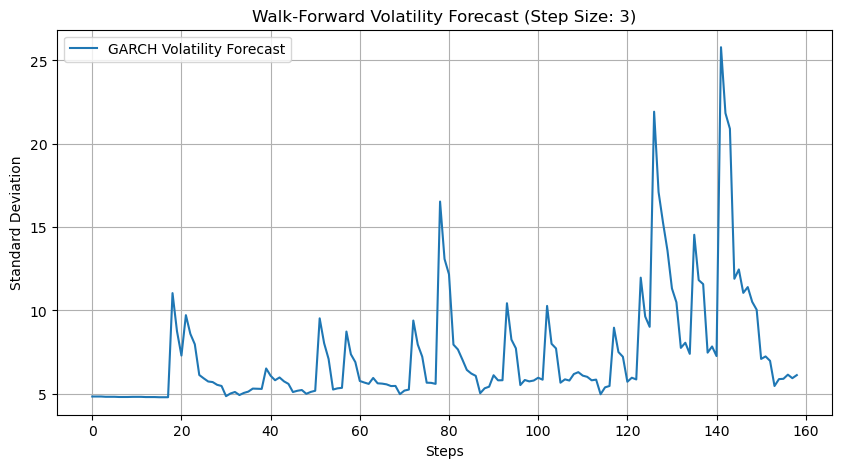

In [26]:
def garch_volatility_forecast(arima_residuals_train, test_residuals, step_size=1, garch_order=(1,1)):
    """
    Walk-forward GARCH volatility forecasting (updated for arch 4.15+)
    
    Parameters:
    arima_residuals_train (array-like): ARIMA residuals from training period
    test_residuals (array-like): ARIMA residuals from test period
    step_size (int): Forecast horizon at each step
    garch_order (tuple): (p,q) order for GARCH model
    
    Returns:
    numpy.ndarray: Standard deviation forecasts (volatility)
    """
    volatility_forecasts = []
    history = list(arima_residuals_train.copy())
    
    for t in range(0, len(test_residuals), step_size):
        # 1. Fit GARCH model
        model = arch_model(history, vol='Garch', p=garch_order[0], q=garch_order[1],dist="t")
        model_fit = model.fit(disp='off')
        
        # 2. Forecast volatility
        steps = min(step_size, len(test_residuals) - t)
        forecast = model_fit.forecast(horizon=steps, reindex=False)
        
        # 3. Get standard deviation - new method for arch 4.15+
        # variance is in .variance, take sqrt to get std dev
        std_dev = np.sqrt(forecast.variance.values[-1, :])
        volatility_forecasts.extend(std_dev)
        
        # 4. Update history with actual test residuals
        history.extend(test_residuals[t:t+steps])
    
    return np.array(volatility_forecasts)

X_test_values=np.array(X_test).reshape(159,)


# Get volatility forecasts
volatility_forecast = garch_volatility_forecast(
    arima_residuals_train=residuals,
    test_residuals=X_test_values-predictions,
    step_size=step_size,
    garch_order=(1,2)
)

# Plot results
plt.figure(figsize=(10, 5))
plt.plot(volatility_forecast, label='GARCH Volatility Forecast')
plt.title(f'Walk-Forward Volatility Forecast (Step Size: {step_size})')
plt.xlabel('Steps')
plt.ylabel('Standard Deviation')
plt.legend()
plt.grid(True)
plt.show()

3 stage Walk-Forward RMSE: 11.4883


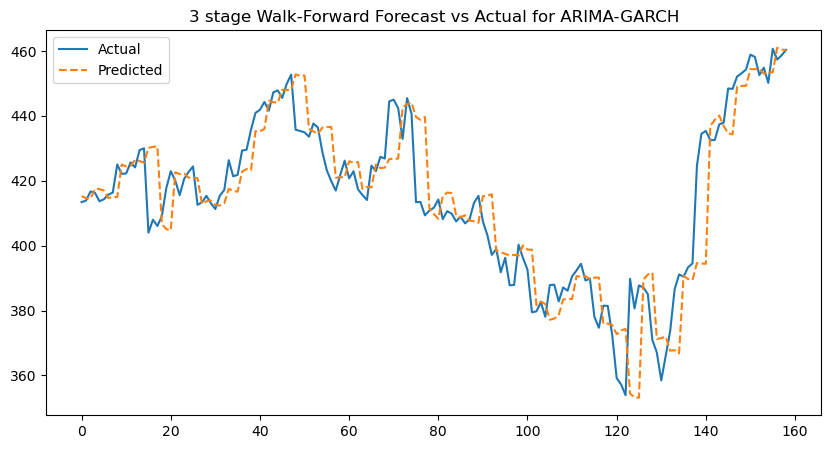

In [36]:
arima_garch_forecast=predictions+0.06*volatility_forecast
rmse = np.sqrt(mean_squared_error(test[:len(predictions)], arima_garch_forecast))
print(f"{step_size} stage Walk-Forward RMSE: {rmse:.4f}")

plt.figure(figsize=(10, 5))
plt.plot(test, label='Actual')
plt.plot(arima_garch_forecast, label='Predicted', linestyle='--')
plt.legend()
plt.title(f"{step_size} stage Walk-Forward Forecast vs Actual for ARIMA-GARCH")
plt.show()
